In [30]:
import os
import numpy as np
import pandas as pd
from time import time

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 26

from utils import preprocessing
from sklearn.feature_extraction import text
from sklearn import decomposition

data_dir = "/home/stavros/DATA/AirbnbReviews"
#data_dir = "D:/"

Load raw reviews (usually not used - **skip to the part where we load normalized reviews**)

In [2]:
area = "south_aegean"
area_dir = os.path.join(data_dir, area)
#file_list = ["listings", "calendar", "reviews"]
file_list = ["reviews"]
data = {k: pd.read_csv(os.path.join(area_dir, "{}.csv.gz".format(k))) for k in file_list}

In [3]:
for k, d in data.items():
    print("\n{} shape: {}".format(k, d.shape))
    for col in d.columns:
        print(col)


reviews shape: (236061, 6)
listing_id
id
date
reviewer_id
reviewer_name
comments


Remove `nan` reviews

In [4]:
clean_reviews = data["reviews"][pd.notnull(data["reviews"].comments)]
print(clean_reviews.shape)

(235997, 6)


### Load normalized reviews
Alternatively, use `apply_normalizer.py` to do the normalization (that generally takes time) and directly load the `DataFrame` that contains a `normalized_comments` column.

In [2]:
area = "nyc"

area_dir = os.path.join(data_dir, area)
sampled_reviews = pd.read_csv(os.path.join(area_dir, "nyc_reviews_nostopwords_en_20000samples.csv"))
print(sampled_reviews.shape)
print(sampled_reviews.columns)

(20000, 8)
Index(['Unnamed: 0', 'listing_id', 'id', 'date', 'reviewer_id',
       'reviewer_name', 'comments', 'normalized_comments'],
      dtype='object')


Note that even though reviews were cleaned before normalizing text, some have `nan` normalized comments (usually this is fixed if we use english only reviews)

In [24]:
clean_sample = sampled_reviews[pd.notnull(sampled_reviews.normalized_comments)]
print(clean_sample.shape)

is_automated = ["canceled" not in review for review in clean_sample.comments]
clean_sample = clean_sample[is_automated]
print(clean_sample.shape)

(20000, 8)
(19739, 8)


Remove host canceled reviews. Let's remove every review that contains the word "canceled" hoping that only the automated reviews contain this word

### Apply TF-IDF to sampled data

In [25]:
vectorizer = text.TfidfVectorizer()
sampled_vectors = vectorizer.fit_transform(clean_sample.normalized_comments)
print(sampled_vectors.shape)

(19739, 14933)


In [26]:
mean_scores = np.array(sampled_vectors.mean(axis=0))[0]
sorted_ids = mean_scores.argsort()[::-1]
print(len(sorted_ids))

vocab = vectorizer.get_feature_names()
important_words = [vocab[i] for i in sorted_ids]
print(important_words[:20])

14933
['great', 'stay', 'place', 'apartment', 'location', 'host', 'nice', 'clean', 'good', 'not', 'room', 'would', 'recommend', 'really', 'time', 'us', 'comfortable', 'subway', 'perfect', 'everything']


SVD of the `sampled_vectors` matrix that TF-IDF analysis calculated

In [27]:
svd = decomposition.TruncatedSVD(n_components=10)
svd_vector = svd.fit_transform(sampled_vectors)
print(svd_vector.shape)
print(svd.explained_variance_)

(19739, 10)
[0.0047171  0.0104001  0.0063449  0.0061648  0.00550323 0.00524239
 0.0048434  0.00472694 0.00443697 0.00438335]


In [28]:
svd.explained_variance_ratio_

array([0.00493356, 0.01087736, 0.00663606, 0.0064477 , 0.00575577,
       0.00548296, 0.00506567, 0.00494386, 0.00464058, 0.0045845 ])

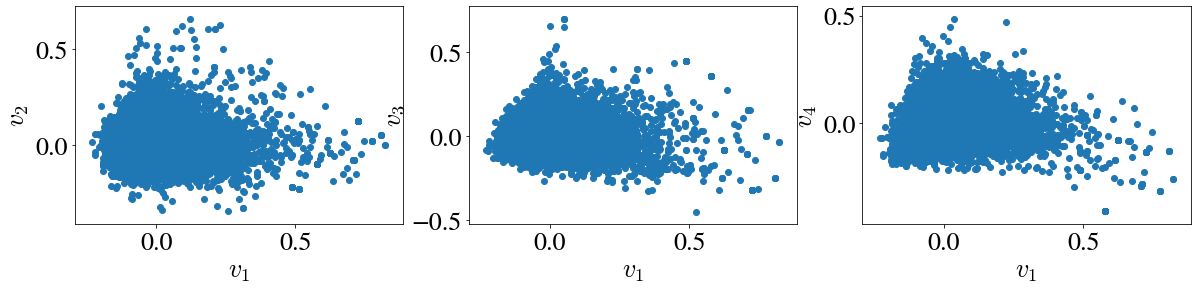

In [31]:
plt.figure(figsize=(20, 4))
component_pairs = [(1, 2), (1, 3), (1, 4)]

for i, (ix, iy) in enumerate(component_pairs):
    plt.subplot(101 + 10 * len(component_pairs) + i)
    plt.scatter(svd_vector[:, ix], svd_vector[:, iy])
    plt.xlabel("$v_{}$".format(ix))
    plt.ylabel("$v_{}$".format(iy))
plt.show()

In [32]:
ids = np.where(svd_vector[:, 1] > 0.5)[0]
len(ids)

110

In [ ]:
for i in range(ids):
    print(clean_sample.iloc[])

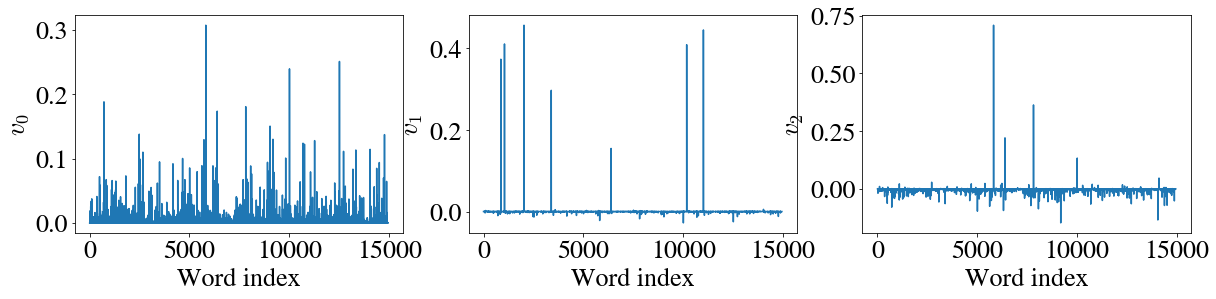

In [16]:
n = 3
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(101 + 10 * n + i)
    plt.plot(svd.components_[i])
    plt.xlabel("Word index")
    plt.ylabel("$v_{}$".format(i))

plt.show()

In [114]:
n_comp = 0
cut_off = 0.07

n_words = (svd.components_[n_comp] > cut_off).sum()
print("num words =", n_words)

if n_words < 50:
    ids = svd.components_[n_comp].argsort()[::-1]
    for i in ids[:n_words]:
        print(vocab[i], svd.components_[n_comp, i])

num words = 33
great 0.39747259703687543
place 0.3166115452258556
stay 0.2824625398288711
location 0.2120381140812257
host 0.19110613908665106
nice 0.1770690063606745
clean 0.1740459854136382
apartment 0.17287421113695844
good 0.14700922121163862
would 0.14433255124467018
recommend 0.1310207883498977
room 0.10998437930521572
comfortable 0.10997722868088451
subway 0.10619589807796725
really 0.1038519632181865
everything 0.10263059380675318
close 0.10255826157006608
definitely 0.1015838768050314
easy 0.0978557054062419
us 0.08886402317397712
need 0.08865568307160224
perfect 0.08831909128560768
time 0.08751321016470444
well 0.081305574515578
walk 0.07584458544523896
get 0.07571387224707163
super 0.07315063400738096
space 0.07292450292486884
make 0.0725467748334978
check 0.07244954467416656
thank 0.07173506131930396
neighborhood 0.07066011255510506
amazing 0.07002086644548865


In [116]:
n_comp = 1
cut_off = 0.07

n_words = (svd.components_[n_comp] > cut_off).sum()
print("num words =", n_words)

if n_words < 50:
    ids = svd.components_[n_comp].argsort()[::-1]
    for i in ids[:n_words]:
        print(vocab[i], svd.components_[n_comp, i])

num words = 7
automate 0.42809491819399575
posting 0.4259364892040187
cancel 0.4188636062503983
reservation 0.41147269841233874
arrival 0.366957862850738
day 0.30767979261898193
host 0.22442450776002273
